### Import all the relevant packages and paths:
    
Importing * from config loads the paths to the example data, machine learning model, the PCA routine, and the binary classifyer parameter.

sauron_colormap is a customised colormap for reducing the region of green in a blue to red colormap so that velocity rotation is a lot easier to see in galaxies. 

In [69]:
import os
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
from torch.utils.data import DataLoader

from config import *
from modules import FITSCubeDataset
from sauron_colormap import sauron

### Load the CAE model and set it to evaluation mode on a cpu device 

Here we are loading the pre-trained convolutional autoencoder and setting it to use the cpu of whatever device is running this script and also setting it to evaluation mode so that internal paramaters and weights don't update during the model testing.

We also  print the different constituent layers of the model as a final step to ensure the model looks like what we expect.

In [8]:
model = torch.load(MODEL_PATH,map_location='cpu').cpu()
model.train(False)
print(model)

Autoencoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lc1): Linear(in_features=4096, out_features=3, bias=True)
  (lc2): Linear(in_features=3, out_features=4096, bias=True)
  (trans1): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (relu): ReLU()
)


### Load the data

Now we need to load the data using PyTorch's inbuilt DataLoader. Here we're using a batch size of 64 and 16 workers to increase the load time. 

In [42]:
test_loader = DataLoader(dataset=FITSCubeDataset(DATA_PATH),
                          batch_size=64,num_workers=16,shuffle=True) 

### Visualising some test data

Here we're going to visualise some of the test velocity maps. In order to look at several examples, simply run the cell below a few times in order to randomly index different examples from within the test_loader.

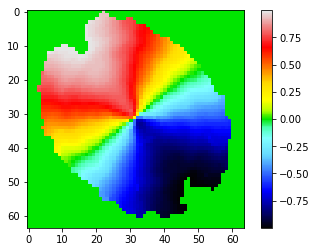

In [96]:
for idx, (batch, names) in enumerate(test_loader):
    batch_data = batch
random_index = randint(0,batch_data.shape[0]-1)

plt.figure()
plt.imshow(batch_data[random_index,0,:,:],cmap=sauron)
plt.colorbar()
plt.show()

### Testing phase

Pass the loaded images through the CAE model and store the results 

In [11]:
all_names = []
all_features = []

for idx, (batch, names) in enumerate(test_loader):
    features,ind1,s1,ind2,s2 = model.encoder(batch.float())
    all_names.append(names)
    all_features.append(features.detach().numpy())
    
all_features = np.hstack(all_features)
all_names = np.hstack(all_names)

### Reorientating the encoded data

So here we've taken the velocity maps and encoded them into a 3 dimensional latent space. This isn't actually the structure that we're going to draw our results from and we still need to reorientate the data so that we can fold out asymmetries. 

For this we're going to use a pre-made PCA routine to rotate the 3d latent data. 

In [14]:
with open(PCA_PATH, 'rb') as file:  
    PCA_model = pickle.load(file)
    
pca_test_data = PCA_model.transform(all_features)

### Visualise the encoded data in folded 2D latent space

Now we're going to fold the latent space over the first dimension as it is seen to be symmetric when visualising the training data in latent space. 

Step 1. Folding the data:

In [15]:
latent_x = np.sqrt((pca_test_data[:,0]**2)+(pca_test_data[:,1]**2))
latent_y = np.abs(pca_test_data[:,2])

Step 2. Visualising the data in 2D:

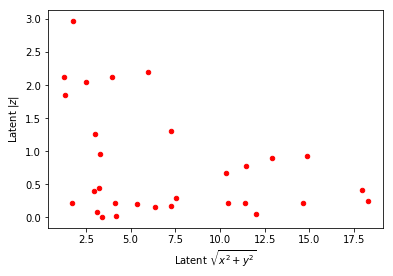

In [97]:
plt.figure()
plt.scatter(latent_x,latent_y,c='r',marker='o',s=20)
plt.xlabel(r'Latent $\sqrt{x^{2} + y^{2}}$')
plt.ylabel(r'Latent $|z|$')
plt.show()

### Get a circularity prediction from the 2D latent positions

Finally we want to get a prediction of circularity for each galaxy based on their positions in the folded 2D latent space. To do this we use the BOUNDARY value imported from the config file.

In [23]:
classifications = np.ones(len(latent_x))
zero_indices = np.where(latent_x<BOUNDARY)[0]
classifications[zero_indices] = 0

### Visualise the results

We can visualise the classifications again using a figure and highlighting the areas of high and low circularity. In the resulting figure we can see the region of high circularity galaxies indicated in green, with the region of low circularity shown in red. For illustration purposes, we can also change the marker shape to help see which galaxies lie in which region close to the boundary line.

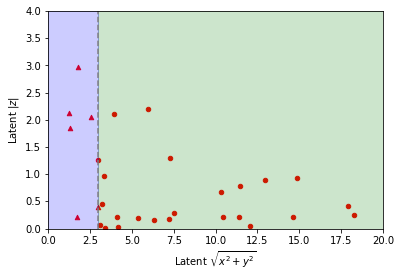

In [98]:
low = np.where(classifications==0)[0]
high = np.where(classifications==1)[0]

fig, ax = plt.figure(), plt.subplot(111)
plt.scatter(latent_x[low],latent_y[low],c='r',marker='^',s=20)
plt.scatter(latent_x[high],latent_y[high],c='r',marker='o',s=20)
plt.vlines(BOUNDARY,0,4,linestyles='--',colors='grey')
ax.axvspan(BOUNDARY, 20, alpha=0.2, color='green')
ax.axvspan(0, BOUNDARY, alpha=0.2, color='blue')
plt.xlabel(r'Latent $\sqrt{x^{2} + y^{2}}$')
plt.ylabel(r'Latent $|z|$'); plt.xlim(0,20)
plt.ylim(0,4)
plt.show()

### Optional - saving the 3D latent positions and classifications 

Here we provide the code for quickly saving the data to a pickled pandas DataFrame. 

In [41]:
df_data = np.vstack([all_names,all_features.T,classifications]).T
results = pd.DataFrame(df_data)
results.columns = ['Name','L1','L2','L3','Circularity']
results.set_index(keys='Name',drop=True,inplace=True)
results.to_pickle(os.path.join(SAVE_PATH,'CAE_results.pkl'))